In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression, LinearRegression


In [70]:
# magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0      Alexander
1         Alonso
2        Anibaba
3           Ashe
4          Avila
         ...    
131       Parker
132        Reyna
133         Shea
134      Techera
135       Waston
Name: last_name, Length: 656, dtype: object

In [177]:
data = []
file_list = [f'archive\jsons\data_{i}.json' for i in range(2013, 2019)]
for file in file_list:
    data.append(pd.read_json(file))
raw_data = pd.concat(data)

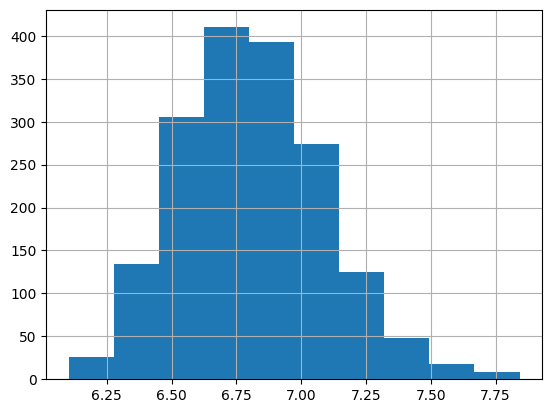

In [182]:
raw_data['rating'].hist()
plt.show()

In [180]:
raw_data['rating'].describe()

count    1742.000000
mean        6.813685
std         0.280188
min         6.102632
25%         6.614158
50%         6.796878
75%         6.990208
max         7.842593
Name: rating, dtype: float64

<AxesSubplot:>

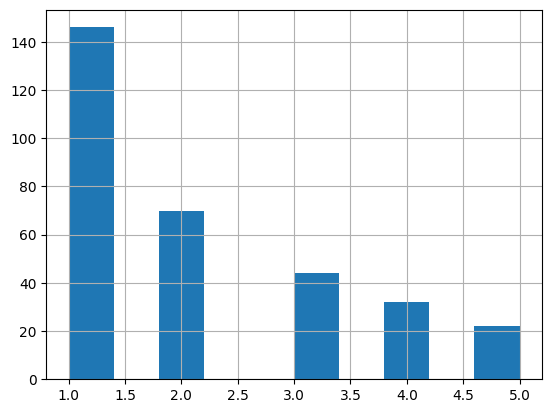

In [199]:
df.groupby(['last_name', 'first_name'])['age_group'].count().hist()

In [71]:
from dataset_creation import create_dataset

In [72]:
df = create_dataset()

c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA

In [200]:
df['age_group'].value_counts()

>35      273
30-35    241
27-30    114
20-27     28
Name: age_group, dtype: int64

In [183]:
len(df)

656

0.4463152856531149

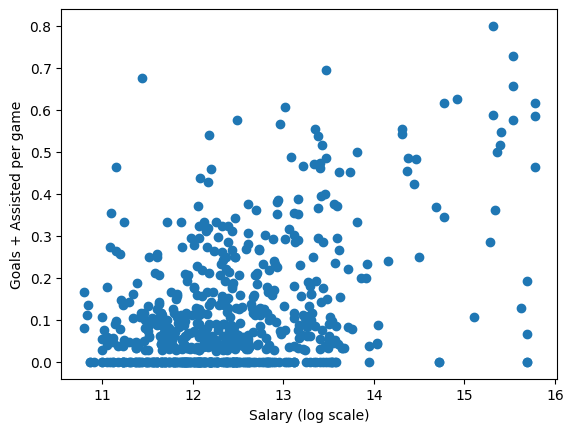

In [74]:
plt.scatter(df["salary_next_year"], df["goals_per_game_next_year"])
plt.xlabel("Salary (log scale)")
plt.ylabel("Goals + Assisted per game")
#  x log scale

# calc correlation
corr = df.corr()
corr.loc["salary_next_year", "goals_per_game_next_year"]


In [168]:
T = df["T"]
# X = pd.get_dummies(df[["salary_next_year", 
#                        "age_group_next_year",
#                        "team_name_next_year",
#                        "rating",
#                        "minutes_per_game_next_year",
#                        "pass_success_next_year",
#                        'shots_per_game_next_year',
#                        ]])

X = pd.get_dummies(df[[
                       "salary",
                    # "added_salary"
                    #    "salary_next_year", 
                       "age_group",
                             "team_name",
                             'rating', 
                             'team_name_next_year', 
                             "shots_per_game",
                             "goals_per_game",
                             "pass_success",
                             "minutes_per_game",
                             'man_of_the_match_per_game','assists_per_game'
                       ]])

Y = df["rating_next_year"]

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
x = pd.get_dummies(df[[ 
                             "shots_per_game",
                             "goals_per_game",
                             "pass_success",
                             "minutes_per_game",
                             'man_of_the_match_per_game','assists_per_game'
                       ]])
y = df['rating']
x, x_test, y, y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8)

In [185]:
linear = LinearRegression().fit(x, y)

In [186]:
mean_squared_error(y_test, linear.predict(x_test))

9.747111862815553e-30

In [187]:
df['age_group']

0      30-35
1        >35
2      30-35
3        >35
4      30-35
       ...  
131    27-30
132    27-30
133    30-35
134    27-30
135    30-35
Name: age_group, Length: 656, dtype: category
Categories (4, object): ['20-27' < '27-30' < '30-35' < '>35']

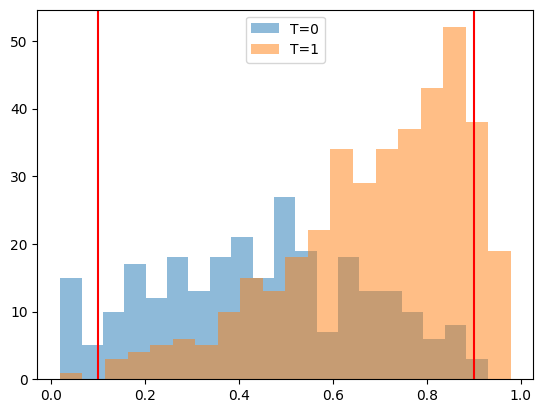

In [169]:
# calc propensity score
from sklearn.linear_model import LogisticRegression, LinearRegression

lr = LogisticRegression(max_iter=1000000)
lr.fit(X, T)
ps = lr.predict_proba(X)[:, 1]

# visualize propensity score
plt.hist(ps[T == 0], bins=20, alpha=0.5, label="T=0")
plt.hist(ps[T == 1], bins=20, alpha=0.5, label="T=1")
plt.legend()


# x line
low_threshold = 0.1 
high_threshold = 0.9
plt.axvline(low_threshold, color="red")
plt.axvline(high_threshold, color="red")


In [170]:
# TODO: trim outliers based on propensity score

# trim outliers
X = X[(ps > low_threshold) & (ps < high_threshold)]
T = T[(ps > low_threshold) & (ps < high_threshold)]
Y = Y[(ps > low_threshold) & (ps < high_threshold)]
ps = ps[(ps > low_threshold) & (ps < high_threshold)]

Text(0.5, 1.0, 'Propensity score after trimming')

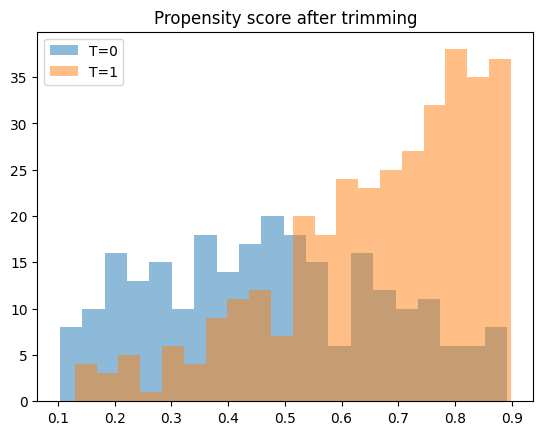

In [171]:
plt.hist(ps[T == 0], bins=20, alpha=0.5, label="T=0")
plt.hist(ps[T == 1], bins=20, alpha=0.5, label="T=1")
plt.legend()

plt.title("Propensity score after trimming")

In [172]:
data = X
data["T"] = T
data["Y"] = Y

In [173]:
def fit_model(data, out_var, ignore=None, max_iter=10000, model_type="logistic"):

    if ignore is None:
        ignore = []
    
    if model_type == "logistic":
        model = LogisticRegression(max_iter=max_iter)
    elif model_type == "linear":
        model = LinearRegression()
    elif isinstance(model_type, sklearn.base.BaseEstimator):
        model = model_type
    else:
        raise ValueError("model_type must be 'logistic' or 'linear'")

    X = data.drop([out_var] + ignore, axis=1)
    y = data[out_var]

    model.fit(X, y)

    return model

def propensity_fitting(data):

    propensity_func = fit_model(data, "T", ignore=["Y"], max_iter=10000)

    return propensity_func


def calc_propensity_score(data, propensity_func):
    X = data.drop(["T", "Y"], axis=1)
    propensity_score = propensity_func.predict_proba(X)[:, 1]
    propensity_score = pd.Series(propensity_score, index=X.index)

    return propensity_score

def IPW_ATE(Y, T, propensity_score):
    return (np.sum(Y[T == 1] / propensity_score[T == 1]) - np.sum(Y[T == 0] / propensity_score[T == 0])) / len(Y)

def calculate_IPW_ATE(data):
    propensity_func = propensity_fitting(data)
    propensity_score = calc_propensity_score(data, propensity_func)
    return IPW_ATE(data["Y"], data["T"], propensity_score)


# S-learner
def fit_y(data):

    y_func = fit_model(data, "Y", max_iter=10000, model_type="linear")

    return y_func

def covariate_adjustment(data, y1_func, y0_func=None):
    if y0_func is None:
        y0_func = y1_func

    X = data.drop(["Y"], axis=1)

    X1 = X.copy()
    X1["T"] = 1
    y1 = y1_func.predict(X1)

    X0 = X.copy()
    X0["T"] = 0
    y0 = y0_func.predict(X0)

    y = y1 - y0

    return y.mean()




def calculate_S_learner_ATE(data):

    y_func = fit_y(data)

    return covariate_adjustment(data, y_func)

# T-learner
def calculate_T_learner_ATE(data):

    y1_func = fit_y(data[data["T"] == 1])
    y0_func = fit_y(data[data["T"] == 0])

    return covariate_adjustment(data, y1_func, y0_func)

from sklearn.neighbors import NearestNeighbors
def calculate_matching_ATE(data, metric="euclidean"):

    knn0 = NearestNeighbors(n_neighbors=1, metric=metric)
    knn1 = NearestNeighbors(n_neighbors=1, metric=metric)

    X = data.drop(["Y", "T"], axis=1)

    knn0.fit(X[data["T"] == 0])
    knn1.fit(X[data["T"] == 1])

    X0 = X[data["T"] == 0]
    X1 = X[data["T"] == 1]

    _, idx0 = knn0.kneighbors(X1)
    _, idx1 = knn1.kneighbors(X0)

    y0 = data["Y"][data["T"] == 0].iloc[idx0[:, 0]]
    y1 = data["Y"][data["T"] == 1].iloc[idx1[:, 0]]

    y0 = data["Y"][data["T"] == 1] - y0
    y1 = y1 - data["Y"][data["T"] == 0]

    return (y0.sum() + y1.sum()) / (len(y0) + len(y1)) 






In [174]:

def calculate_ATE(data, method="IPW"):
    if method == "IPW":
        return calculate_IPW_ATE(data)
    elif method == "S-learner":
        return calculate_S_learner_ATE(data)
    elif method == "T-learner":
        return calculate_T_learner_ATE(data)
    elif method == "matching":
        return calculate_matching_ATE(data)
    else:
        raise ValueError("method must be 'IPW', 'S-learner', 'T-learner', or 'matching'")

# estimate variance using bootstrap
def estimate_variance(data, method="IPW", n_iter=1000, random_state=0, sample_size=None):
    np.random.seed(random_state)

    if sample_size is None:
        sample_size = len(data)

    ate_list = []
    for _ in range(n_iter):
        idx = np.random.choice(data.index, size=sample_size, replace=True)
        ate_list.append(calculate_ATE(data.loc[idx], method=method))

    ate_list = np.array(ate_list)
    return ate_list.std()



In [175]:
# tabulate all results
methods = ["IPW", "S-learner", "T-learner", "matching"]
results = pd.DataFrame(index=methods, columns=["ATE", "std"])

for method in methods:
    results.loc[method, "ATE"] = calculate_ATE(data, method=method)
    results.loc[method, "std"] = estimate_variance(data, method=method, n_iter=100, sample_size=100)
    # add 95% confidence interval
    results.loc[method, "ATE (95% CI)"] = f"{results.loc[method, 'ATE']:.3f} ± {1.96 * results.loc[method, 'std']:.3f}"

print(tabulate(results, headers="keys", tablefmt="github"))

|           |          ATE |       std | ATE (95% CI)   |
|-----------|--------------|-----------|----------------|
| IPW       | -1.09142     | 2.11445   | -1.091 ± 4.144 |
| S-learner | -0.00855061  | 0.0221756 | -0.009 ± 0.043 |
| T-learner | -0.0060734   | 0.0226236 | -0.006 ± 0.044 |
| matching  | -0.000234985 | 0.0247002 | -0.000 ± 0.048 |


In [83]:
Y.min()

6.186999999999999

In [84]:

X.shape

(609, 37)

In [85]:
# def read_mls_salaries(data_path, year):

#     salaries_year = pd.read_csv(os.path.join(data_path, f"mls-salaries-{year}.csv"))

#     salaries_year["salary"] = salaries_year["guaranteed_compensation"]

#     salaries_year = salaries_year[salaries_year["position"].str.contains("F") 
#                                   & (~salaries_year["position"].isna())]

#     salaries_year = salaries_year[["first_name", "last_name", "salary"]]

#     return salaries_year

# def read_stats_data(data_path, year):

#     stats_year = pd.read_json(os.path.join(data_path, f"data_{year}.json"))

#     stats_year["age_group"] = pd.cut(stats_year["age"], 
#                          bins=[20, 27, 30, 35, 100], 
#                          labels=["20-27", "27-30", "30-35", ">35"])

    
#     stats_year["goals_per_game"] = (stats_year["goal"] + stats_year["assistTotal"]) / stats_year["apps"]
#     stats_year["shots_per_game"] = stats_year["shotsPerGame"] # / stats_year["apps"]
#     stats_year["minutes_per_game"] = stats_year["minsPlayed"] / stats_year["apps"]

#     stats_year = stats_year.rename(columns={"teamName": "team_name",
#                                             "passSuccess": "pass_success",
#                                             "firstName": "first_name",
#                                             "lastName": "last_name"})

#     stats_year = stats_year[["age_group", 
#                              "team_name", 
#                              "shots_per_game", 
#                              "goals_per_game",
#                              "pass_success",
#                              "rating",
#                              "minutes_per_game",
#                              "first_name",
#                              "last_name"]]


#     # stats_year = pd.get_dummies(stats_year, columns=["age_group", "team_name"])


#     return stats_year



In [86]:
# def merge_datasets(year, data_path):
#     merge_on = ["last_name", "first_name"]


#     salaries_path = os.path.join(data_path, "csvs")

#     salaries_year = read_mls_salaries(salaries_path, year)
#     salaries_next_year = read_mls_salaries(salaries_path, year + 1)



#     # Merge the two datasets
#     salaries_merged = pd.merge(salaries_year, 
#                                salaries_next_year, 
#                                on=merge_on, 
#                                how="inner",
#                                suffixes=("", "_next_year"))


#     added_salary = (salaries_merged["salary_next_year"] - salaries_merged["salary"]) / salaries_merged["salary"] 
#     salaries_merged["added_salary"] = added_salary

#     salaries_merged = salaries_merged[salaries_merged["added_salary"] > -0.1]
#     salaries_merged["T"] = salaries_merged["added_salary"] > 0.1
    
#     stats_path = os.path.join(data_path, "jsons")

#     stats_year = read_stats_data(stats_path, year)
#     stats_next_year = read_stats_data(stats_path, year + 1)


#     # Merge the two datasets
#     stats_merged = pd.merge(stats_year,
#                             stats_next_year,    
#                             on=merge_on,
#                             how="inner",
#                             suffixes=("", "_next_year"))

    
#     a1 = salaries_merged.columns
#     a2 = stats_merged.columns
#     a3 = np.intersect1d(a1, a2)
#     a3 = a3[~np.isin(a3, merge_on)]

    
#     assert len(a3) == 0, "There are columns with the same name in both datasets"

#     # Merge the two datasets
#     merged = pd.merge(salaries_merged,
#                       stats_merged,
#                         on=merge_on,
#                         # left_on=["last_name", "first_name"],
#                         # right_on=["lastName", "firstName"],
#                         how="inner")

#     return merged
    



In [87]:
# df = pd.DataFrame()

# for year in range(2013, 2018):

#     # df = merge_datasets(year, "archive")
#     df = df.append(merge_datasets(year, "archive"))


In [88]:
df

,first_name,last_name,salary,salary_next_year,added_salary,T,age_group,team_name,shots_per_game,goals_per_game,...,assists_per_game,age_group_next_year,team_name_next_year,shots_per_game_next_year,goals_per_game_next_year,pass_success_next_year,rating_next_year,minutes_per_game_next_year,man_of_the_match_per_game_next_year,assists_per_game_next_year
0,Eric,Alexander,11.168567,11.765628,0.816771,True,30-35,New York,0.972222,0.138889,...,0.055556,30-35,New York,0.769231,0.051282,85.806037,6.695641,77.692308,0.000000,0.179487
1,Osvaldo,Alonso,12.254863,12.899220,0.904762,True,>35,Seattle,1.241379,0.034483,...,0.034483,>35,Seattle,0.972222,0.027778,91.019523,7.322222,88.111111,0.111111,0.000000
2,Jalil,Anibaba,11.784821,11.980551,0.216199,True,30-35,Chicago,0.500000,0.029412,...,0.000000,30-35,Seattle,0.470588,0.000000,79.840319,6.630588,75.588235,0.000000,0.058824
3,Corey,Ashe,11.568833,12.071112,0.652482,True,>35,Houston,0.235294,0.000000,...,0.058824,>35,Houston,0.380952,0.000000,77.215190,6.574762,89.476190,0.000000,0.095238
4,Eric,Avila,11.695247,11.813030,0.125000,True,30-35,Chivas,0.964286,0.107143,...,0.000000,30-35,Chivas,0.551724,0.000000,75.841346,6.533793,74.896552,0.000000,0.034483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,Tim,Parker,11.508917,11.660785,0.164006,True,27-30,Vancouver,0.571429,0.028571,...,0.057143,27-30,New York,0.545455,0.060606,73.189009,7.053030,90.000000,0.060606,0.060606
132,Yordy,Reyna,13.187589,13.187589,0.000000,False,27-30,Vancouver,1.285714,0.285714,...,0.142857,27-30,Vancouver,1.653846,0.230769,84.433164,6.924615,72.230769,0.076923,0.346154
133,Brek,Shea,13.415033,13.521139,0.111940,True,30-35,Vancouver,0.821429,0.142857,...,0.107143,30-35,Vancouver,0.857143,0.107143,75.660377,6.405000,54.357143,0.000000,0.071429
134,Cristian,Techera,12.840000,12.928779,0.092838,False,27-30,Vancouver,1.812500,0.218750,...,0.125000,27-30,Vancouver,2.095238,0.380952,75.232198,6.572857,64.190476,0.047619,0.047619


In [89]:
# added_salary = (df["guaranteed_compensation_next_year"] - df["guaranteed_compensation"]) / df["guaranteed_compensation"] 
# df["added_salary"] = added_salary

# df = df[df["added_salary"] > -0.1]
# df["T"] = df["added_salary"] > 0.1

# df = df[df["position"].str.contains("F")]

In [90]:
 df["T"].value_counts()

True     388
False    268
Name: T, dtype: int64

In [91]:
# df["shotsPerGame"]

In [92]:
# df.position.value_counts()

In [93]:
# df["shotsPerGame"].hist()

In [94]:
# [col for col in df.columns if "next_year" not in col]

In [95]:
# df["first_name"]

In [96]:
df["club"].unique()

KeyError: 'club'

In [ ]:
df["teamName"].unique()

KeyError: 'teamName'

In [ ]:
df[df["club"] == "NY"]["teamName"].unique()

KeyError: 'club'

In [ ]:
# age groups
# 20 - 27
# 27 - 30
# 30 - 35
# 35 - 100


                         

In [ ]:
df["goals_normalized"] = (df["goal"] + df["assistTotal"]) / df["apps"]
df["shotsPerGame"] = df["shotsPerGame"] / df["apps"]

In [ ]:
pd.read_json('archive\data_2017.json').corr()['rating']

height               -0.067012
weight               -0.051652
age                   0.220681
isManOfTheMatch            NaN
isActive             -0.023046
apps                  0.609078
subOn                -0.234058
manOfTheMatch         0.568709
goal                  0.457645
assistTotal           0.525465
shotsPerGame          0.456561
aerialWonPerGame      0.324188
playerId             -0.323037
teamId                0.017877
seasonId                   NaN
seasonName                 NaN
isOpta                     NaN
tournamentId               NaN
tournamentRegionId         NaN
rating                1.000000
minsPlayed            0.689458
yellowCard            0.483452
redCard               0.060715
passSuccess           0.129117
ranking              -0.966966
Name: rating, dtype: float64

In [ ]:
correlations = create_dataset().corr()['rating_next_year']

c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA

In [ ]:
create_dataset()['manOfTheMatch'].value_counts()

c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append 

0     248
1     179
2     113
3      45
4      31
5      18
6       9
7       6
9       3
10      1
14      1
12      1
8       1
Name: manOfTheMatch, dtype: int64

In [ ]:
create_dataset().corr()['rating_next_year'].index

c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA

Index(['salary', 'salary_next_year', 'added_salary', 'T', 'height', 'weight',
       'age', 'isManOfTheMatch', 'isActive', 'apps', 'subOn', 'manOfTheMatch',
       'goal', 'assistTotal', 'shotsPerGame', 'aerialWonPerGame', 'playerId',
       'teamId', 'seasonId', 'seasonName', 'isOpta', 'tournamentId',
       'tournamentRegionId', 'rating', 'minsPlayed', 'yellowCard', 'redCard',
       'pass_success', 'ranking', 'goals_per_game', 'shots_per_game',
       'minutes_per_game', 'height_next_year', 'weight_next_year',
       'age_next_year', 'isManOfTheMatch_next_year', 'isActive_next_year',
       'apps_next_year', 'subOn_next_year', 'manOfTheMatch_next_year',
       'goal_next_year', 'assistTotal_next_year', 'shotsPerGame_next_year',
       'aerialWonPerGame_next_year', 'playerId_next_year', 'teamId_next_year',
       'seasonId_next_year', 'seasonName_next_year', 'isOpta_next_year',
       'tournamentId_next_year', 'tournamentRegionId_next_year',
       'rating_next_year', 'minsPlayed_nex

In [ ]:
for i in create_dataset().corr()['rating_next_year'].index:
    print(i)


salary
salary_next_year
added_salary
T
height
weight
age
isManOfTheMatch
isActive
apps
subOn
manOfTheMatch
goal
assistTotal
shotsPerGame
aerialWonPerGame
playerId
teamId
seasonId
seasonName
isOpta
tournamentId
tournamentRegionId
rating
minsPlayed
yellowCard
redCard
pass_success
ranking
goals_per_game
shots_per_game
minutes_per_game
height_next_year
weight_next_year
age_next_year
isManOfTheMatch_next_year
isActive_next_year
apps_next_year
subOn_next_year
manOfTheMatch_next_year
goal_next_year
assistTotal_next_year
shotsPerGame_next_year
aerialWonPerGame_next_year
playerId_next_year
teamId_next_year
seasonId_next_year
seasonName_next_year
isOpta_next_year
tournamentId_next_year
tournamentRegionId_next_year
rating_next_year
minsPlayed_next_year
yellowCard_next_year
redCard_next_year
pass_success_next_year
ranking_next_year
goals_per_game_next_year
shots_per_game_next_year
minutes_per_game_next_year


c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA\Causal Inference\Project\Casual-Inference-Soccer-main\Casual-Inference-Soccer-main\dataset_creation.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merge_datasets(year, "archive"))
c:\Users\10\Documents\SemesterA